<a href="https://colab.research.google.com/github/Ravio1i/ki-lab/blob/master/2_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from time import time

In [2]:
# Tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Data

In [3]:
#@title Data parameters
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size =  4#@param {type:"integer"}
num_workers = 2#@param {type:"integer"}

#@tex Data
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Pre

In [4]:
def imshow(img):
    img = img /2 + 0.5
    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

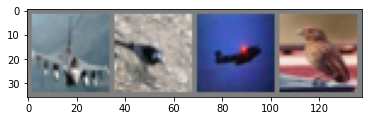

plane  bird plane  bird


In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(" ".join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Convolutional Neural Network

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Calculate size of conv net output layer with [(W−K+2P)/S]+1
        # Parameters of Conv2d: Input Channels, number of filters, filter size
        self.conv1 = nn.Conv2d(3, 8, 3)
        # Output Size: 32-3+1=30
        self.conv2 = nn.Conv2d(8, 16, 3)
        # Output Size: 30-3+1=28
        self.pool = nn.MaxPool2d(2)
        # Output Size: 28/2=14
        self.conv3 = nn.Conv2d(16, 32, 3)
        # Output Size: 14-3+1=12
        self.conv4 = nn.Conv2d(32, 64, 3)
        # Output Size: 12-3+1=10
        # Input of FC is product of output_dim of last conv layer, Kernel Width, Kernel Height
        # Output of FC Layer is number of nodes
        self.fc1 = nn.Linear(64 * 5 * 5, 4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Train

In [7]:
def train(n_epochs: int = 2):
    print("""
    Device: {}
    Epochs (n): {}
    Log interval: {}
    Criterion: {}
    Optimizer: {}
    """.format(device, n_epochs, log_interval, criterion, optimizer))
    time_start = time()
    for epoch in range(n_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            # Write to tensorboard
            writer.add_scalar("Loss/train", loss, epoch)
            # Backprop
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            if (i+1) % log_interval == 0:
                print('[%d, %5d] loss: %.3f' % (epoch +1, i +1, running_loss / log_interval))
                running_loss = 0.0
    
    time_compl = (time()-time_start)/60
    print("Training Time (in minutes) = {}".format(time_compl))
    print('Finished training')
    #torch.save(net.state_dict(), PATH)

## Test

In [34]:
def test(topk: int = 1):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            # Get best output from output data
            total += labels.size(0)

            if topk > 1:
                _, predicted = torch.topk(outputs.data, topk)
                for i, label in enumerate(labels):
                    correct += 1 if label in predicted[i] else 0
                continue
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    print('Accuracy with predition in top {} of labels = {}'.format(topk, (100 * correct / total)))

In [9]:
def test_sample():
    dataiter = iter(testloader)
    images, labels = dataiter.next()

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

    outputs = net(images.to(device))
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                for j in range(4)))

## Analyze

In [11]:
def analyze():
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [27]:
def analyze_wrong(count: int=5):
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    not_c = (predicted != labels).squeeze()
    while j < 5:
        if not not_c[j]: continue
        img_grid = torchvision.utils.make_grid(images)
        imshow(torchvision.utils.make_grid(images))
        print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
        writer.add_image('Not correct predicted', img_grid)

# Run

## Hyper Parameters

In [12]:
learning_rate = 0.001#@param {type:"number"}
momentum = 0.9#@param {type:"number"}
log_interval = 2000#@param {type:"integer"}
# PATH = './cifar_net.pth'#@param {type:"string"}


## CUDA

In [24]:
device = torch.device("cuda:0")

net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [25]:
train(2)


    Device: cuda:0
    Epochs (n): 2
    Log interval: 2000
    Criterion: CrossEntropyLoss()
    Optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
    
[1,  2000] loss: 2.248
[1,  4000] loss: 1.924
[1,  6000] loss: 1.725
[1,  8000] loss: 1.623
[1, 10000] loss: 1.509
[1, 12000] loss: 1.458
[2,  2000] loss: 1.347
[2,  4000] loss: 1.304
[2,  6000] loss: 1.265
[2,  8000] loss: 1.214
[2, 10000] loss: 1.168
[2, 12000] loss: 1.135
Training Time (in minutes) = 2.59353457291921
Finished training


In [ ]:
test()
test(topk=3)
#test_sample()

Accuracy with predition in top 1 of labels = 59.86


## CPU

In [16]:
device = torch.device("cpu")

net = Net()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [17]:
train(2)


    Device: cpu
    Epochs (n): 2
    Log interval: 2000
    Criterion: CrossEntropyLoss()
    Optimizer: SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
    


KeyboardInterrupt: ignored

In [ ]:
test()

# Tensorboard

In [ ]:
writer.flush()
writer.close()
%reload_ext tensorboard
%tensorboard --logdir runs